In [154]:
import random
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import deque, namedtuple
import torch.nn as nn
import numpy as np
import imageio
%matplotlib inline

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda"


class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_space_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64 * 2),
            nn.ReLU(),
            nn.Linear(64 * 2, action_space_dim)
        )

    def forward(self, x):
        x = x.to(device)
        return self.net(x)


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQNAgent(object):

    def __init__(self):

        self.env = gym.make('Acrobot-v1')

        state_space_dim = self.env.observation_space.shape[0]
        action_space_dim = self.env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"STATE SPACE SIZE: {state_space_dim}")
        print(f"ACTION SPACE SIZE: {action_space_dim}")

        self.hp_d = {'gamma': 0.99,
                     'replay_memory_capacity': 10000,
                     'lr': 1e-3,
                     'target_net_update_steps': 10,
                     'batch_size': 256,
                     'bad_state_penalty': 0,
                     'min_samples_for_training': 1000}

        # replay memory
        self.replay_memory = ReplayMemory(self.hp_d['replay_memory_capacity'])

        # policy network
        policy_net = DQN(state_space_dim, action_space_dim).to(device)
        target_net = DQN(state_space_dim, action_space_dim).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        optimizer = torch.optim.Adam(policy_net.parameters(), lr=self.hp_d['lr'])

        self.net_d = {'policy_net': policy_net,
                      'target_net': target_net,
                      'optimizer': optimizer,
                      'loss_fn': nn.SmoothL1Loss()
                      }

        ### Define exploration profile

        initial_value = 5
        num_iterations = 800
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6)

        self.exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

        pass

    def run(self):
        # for constant container, we are not going to extract them
        # but variables, we will extract them
        # all there are in order for code neatness
        env = self.env
        policy_net = self.net_d['policy_net']
        target_net = self.net_d['target_net']
        optimizer = self.net_d['optimizer']
        loss_fn = self.net_d['loss_fn']

        self.plotting_rewards = []

        for episode_num, tau in enumerate(tqdm(self.exploration_profile)):

            state, _ = env.reset()
            state = state.tolist()
            score = 0
            terminated = False
            truncated = False

            while not terminated and not truncated:

                # Choose the action following the policy
                action, q_values = self.choose_action_softmax(policy_net, state, temperature=tau)

                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = next_state.tolist()
                # Update the final score (-1 for each step)
                score += reward

                if terminated:
                    reward += self.hp_d['bad_state_penalty']
                    next_state = None

                # Update the replay memory

                self.replay_memory.push(state, action, next_state, reward)

                # Update the network
                if len(self.replay_memory) > self.hp_d['min_samples_for_training']:
                    # we enable the training only if we have enough samples in the replay memory,
                    # otherwise the training will use the same samples too often
                    self.update_step(policy_net, target_net, self.replay_memory, self.hp_d['gamma'], optimizer, loss_fn,
                                     self.hp_d['batch_size'])
                # Set the current state for the next iteration
                state = next_state

            # Update the target network every target_net_update_steps episodes
            if episode_num % self.hp_d['target_net_update_steps'] == 0:
                print('Updating target network...')
                target_net.load_state_dict(
                    policy_net.state_dict())  # This will copy the weights of the policy network to the target network
            self.plotting_rewards.append(score)
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}")  # Print the final score
        torch.save(policy_net, 'policy_net.pt')
        env.close()

    def update_step(self, policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        # Sample from the replay memory
        batch = replay_mem.sample(batch_size)
        batch_size = len(batch)

        # Create tensors for each element of the batch
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
        rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

        # Compute a mask of non-final states (all the elements where the next state is not None)
        non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32,
                                             device=device)  # the next state can be None if the game has ended
        non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

        # Compute Q values
        policy_net.train()
        q_values = policy_net(states)
        # Select the proper Q value for the corresponding action taken Q(s_t, a)
        state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

        # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
        with torch.no_grad():
            target_net.eval()
            q_values_target = target_net(non_final_next_states)
        next_state_max_q_values = torch.zeros(batch_size, device=device)
        next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = rewards + (next_state_max_q_values * gamma)
        expected_state_action_values = expected_state_action_values.unsqueeze(1)  # Set the required tensor shape

        # Compute the Huber loss
        loss = loss_fn(state_action_values, expected_state_action_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping
        nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
        optimizer.step()

    def choose_action_epsilon_greedy(self, net, state, epsilon):

        if epsilon > 1 or epsilon < 0:
            raise Exception('The epsilon value must be between 0 and 1')

        # Evaluate the network output from the current state
        with torch.no_grad():
            net.eval()
            state = torch.tensor(state, dtype=torch.float32)  # Convert the state to tensor
            net_out = net(state)

        # Get the best action (argmax of the network output)
        best_action = int(net_out.argmax())
        # Get the number of possible actions
        action_space_dim = net_out.shape[-1]

        # Select a non optimal action with probability epsilon, otherwise choose the best action
        if random.random() < epsilon:
            # List of non-optimal actions (this list includes all the actions but the optimal one)
            non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
            # Select randomly from non_optimal_actions
            action = random.choice(non_optimal_actions)
        else:
            # Select best action
            action = best_action

        return action, net_out.cpu().numpy()

    def choose_action_softmax(self, net, state, temperature):
        if temperature < 0:
            raise Exception('The temperature value must be greater than or equal to 0 ')

        # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
        if temperature == 0:
            return self.choose_action_epsilon_greedy(net, state, 0)

        # Evaluate the network output from the current state
        with torch.no_grad():
            net.eval()
            state = torch.tensor(state, dtype=torch.float32)
            net_out = net(state)

        # Apply softmax with temp
        temperature = max(temperature, 1e-8)  # set a minimum to the temperature for numerical stability
        softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()

        # Sample the action using softmax output as mass pdf
        all_possible_actions = np.arange(0, softmax_out.shape[-1])
        # this samples a random element from "all_possible_actioimageio.mimsave('test.gif', frames, duration=1 / 60)ns" with the probability distribution p (softmax_out in this case)
        action = np.random.choice(all_possible_actions, p=softmax_out)

        return action, net_out.cpu().numpy()

    def test(self, path_name, episodes=10, render=False, gif_name='test.gif'):

        if episodes > 10 and render:
            raise Exception('Cannot render more than 10 episodes')

        # test the model
        env = gym.make('Acrobot-v1', render_mode='rgb_array')
        policy_net = torch.load(path_name)
        policy_net.eval()
        score_history = []
        frames = []
        for i in tqdm(range(episodes)):
            state, _ = env.reset()
            terminated = False
            truncated = False
            score = 0
            while not terminated and not truncated:

                if render:
                    frames.append(env.render())

                # action, _ = self.choose_action_softmax(policy_net, state, 0.01)
                action, _ = self.choose_action_epsilon_greedy(policy_net, state, 0)
                state, reward, terminated, truncated, _ = env.step(action)
                score += reward
            score_history.append(score)
        env.close()
        plt.plot(score_history)
        plt.show()

        if render:
            self.save2gif(frames, gif_name)
        return score_history

    def save2gif(self, frames, name):
        imageio.mimsave(name, frames, duration=0.05)


test = DQNAgent()
# test.run()
# test.test()


STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [136]:
test.run()

  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.940008876649582
EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.485279683605809
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -500

  0%|          | 0/10 [00:00<?, ?it/s]

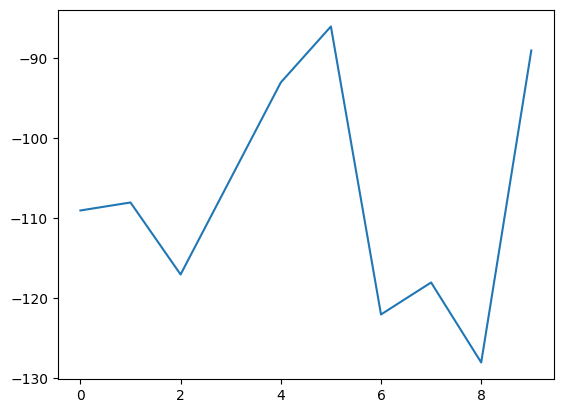

-107.5


In [156]:
a = test.test('test_t_and_t.pt', episodes=10, render=True, gif_name='test_t_and_t.gif')
b = np.array(a)
print(b.mean())

  0%|          | 0/10 [00:00<?, ?it/s]

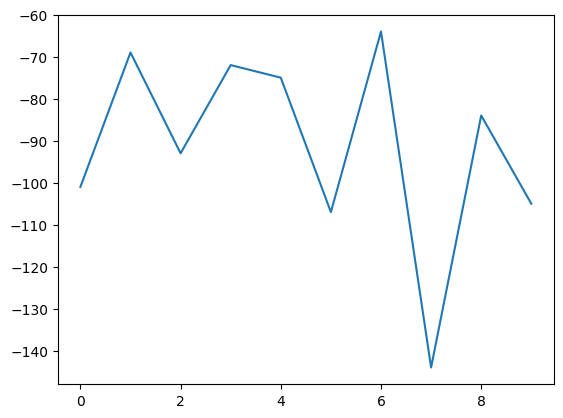

-91.4


In [157]:
a = test.test('test_terminated_1.pt', episodes=10, render=True, gif_name='test_terminated_1.gif')
b = np.array(a)
print(b.mean())

  0%|          | 0/10 [00:00<?, ?it/s]

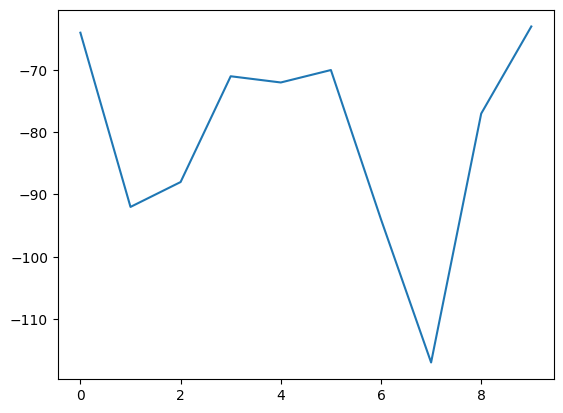

-80.8


In [159]:
a = test.test('test_terminated_2.pt', episodes=10, render=True, gif_name='test_terminated_2.gif')
b = np.array(a)
print(b.mean())